In [1]:
# import general packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [3]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses.shape # subs *movies

(1048, 10)

In [4]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vidnames

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [5]:
from mne.stats import fdr_correction
from multipy.fdr import lsu
#from multipy.data import neuhaus


# (1) social v unsure v nonsocial

## Random Mech

In [6]:
movie_ind = 4
coef_slope_rand = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','coef_slopereg_runnorm_Random mechanical.npy'))

soc_inds = responses[:,movie_ind]==1 # subs who responded "social"
nonsoc_inds = responses[:,movie_ind]==0 # subs who respoded "nonsocial"
unsure_inds = responses[:,movie_ind]==9 # subs who respoded "unsure"

print(f'movie={vidnames[movie_ind]},soc={len(np.where(soc_inds)[0])},nonsocial={len(np.where(nonsoc_inds)[0])},unsure={len(np.where(unsure_inds)[0])}')

# ttest between slope regs yes vs. no
_,pval_slope_rand_S_NS = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_NS = lsu(pval_slope_rand_S_NS,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_NS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

# ttest between slope regs yes vs. unsure
_,pval_slope_rand_S_UNS_unc = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[unsure_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_UNS = lsu(pval_slope_rand_S_UNS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_UNS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)

# ttest between slope regs unsure vs. no
_,pval_slope_rand_UNS_NS_unc = stats.ttest_ind(coef_slope_rand[unsure_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_UNS_NS = lsu(pval_slope_rand_UNS_NS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_UNS_NS = np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

pval_slope_rand_UNS_NS_unc = pval_slope_rand_UNS_NS_unc<.05
pval_slope_rand_S_UNS_unc = pval_slope_rand_S_UNS_unc < .05

movie=Random mechanical,soc=88,nonsocial=587,unsure=186


In [7]:
# social>unsure and unsure>non-social or vice-versa, both corrected
nodes_rand_SUNS_UNSNS = (pval_slope_rand_S_UNS) & (pval_slope_rand_UNS_NS) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS:',len(np.where(nodes_rand_SUNS_UNSNS)[0])) # no sig  ndoes for RAND

#### same as above, unc.
# social>unsure and unsure>non-social or vice-versa, both uncorrected
nodes_rand_SUNS_UNSNS_unc = (pval_slope_rand_S_UNS_unc) & (pval_slope_rand_UNS_NS_unc) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS_unc:',len(np.where(nodes_rand_SUNS_UNSNS_unc)[0])) # 10 sig nodes for RAND


nodes_rand_SUNS_UNSNS: 0
nodes_rand_SUNS_UNSNS_unc: 14


- overall, 10 nodes show  S>unsure>NS at the uncorrected threshold for both


In [8]:
# for comparison with the other main figure if needed
#nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy')) # sig nodes hihglighted in the first S>NS GLM
#nodes_randuns_all = nodes_coaxbill_rand_all & nodes_rand_SNS_SUNS
#len(np.where(nodes_randuns_all)[0])

## All movies S > Unsure >NS

- for the all movies social v unsure v nonsocial analysis, we need trial-wise coeffts (the all movies analyses for the main results was from run-norm data where social and nonsocial were assigned positive and negative slopes - no way to correctly include unsure here - hence the need for trialwise reg coeffts) 

In [9]:
# first of all, best to remove subjects with < 10 responses for power in general
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0])
subs_10resp = np.where(count_resp == 10)[0]
len(subs_10resp)

814

In [10]:
#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm
import time

In [11]:
# initializing arrays
coef_soc_uns, coef_uns_nonsoc, coef_soc_nonsoc = [np.empty((268,)) for _ in range(3)]
coef_soc_uns[:], coef_uns_nonsoc[:], coef_soc_nonsoc[:]  = [np.nan]*3

pval_soc_uns, pval_uns_nonsoc, pval_soc_nonsoc = [np.empty((268,)) for _ in range(3)]
pval_soc_uns[:], pval_uns_nonsoc[:], pval_soc_nonsoc[:] = [np.nan]*3

In [12]:
# creating a 3D array of beta coeffs across movies from individual movie files
all_coefs = np.zeros((1048,268,10))

for m in range(10):
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_{vidnames[m]}.npy')
    all_coefs[:,:,m] = np.load(fileName)
    #print(dat.shape)

In [13]:
other_movies = [0,1,2,3,5,6,7,8,9] # do the analyses on all movies except rand mech

In [63]:
# Yes v Unsure
start_time =  time.time()
for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in other_movies:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})

        df = df.append(df_temp,ignore_index=True)
        df = df.loc[df['response'] != 0] # yes v unsure
    df['response'] = df['response'].map({1.0: "Social", 9.0:  "Unsure"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Unsure","Social"]},summary = False, verbose = False)
    if n == 0:
        print('model:',model.fit(factors={"response":["Unsure","Social"]}))
    coef_soc_uns[n] = model.coefs['Estimate'][1]
    pval_soc_uns[n]= model.coefs['P-val'][1]


node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 4258	 Groups: {'subID': 814.0}

Log-likelihood: -5488.839 	 AIC: 10977.679

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.095  0.308
Residual               0.695  0.833

No random effect correlations specified

Fixed effects:

model:              Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.253   0.155    0.351  0.050  4202.614   5.060  0.000  ***
response1       0.140   0.040    0.239  0.051  4143.739   2.758  0.006   **
node 11,time=0.06 mins
node 21,time=0.11 mins
node 31,time=0.16 mins
node 41,time=0.22 mins
node 51,time=0.28 mins
node 61,time=0.33 mins
node 71,time=0.38 mins
node 81,time=0.43 mins
node 91,time=0.48 mins
node 101,time=0.53 mins
node 111,time=0.59 mins
node 121,time=0.64 mins
node 131,time=0.69 mins
node 141,time=0.74 mins
node 151,time=0.79 mins
node 161,time=0.84 mins
node 171,

Text(0.5, 0, 'Social>Unsure')

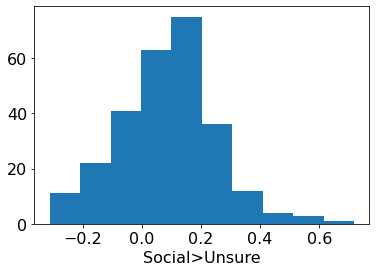

In [64]:
plt.hist(coef_soc_uns)
plt.xlabel('Social>Unsure')

In [65]:
start_time =  time.time()
for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in other_movies:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
        df = df.loc[df['response'] != 1] # no v unsure
        
    df['response'] = df['response'].map({0.0: "Non-social", 9.0:  "Unsure"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Non-social","Unsure"]},summary = False, verbose = False)
    if n == 0:
        print(model.fit(factors={"response":["Non-social","Unsure"]}))
    #print('model 2:',model.fit())
    coef_uns_nonsoc[n] = model.coefs['Estimate'][1]
    pval_uns_nonsoc[n]= model.coefs['P-val'][1]


node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 3388	 Groups: {'subID': 813.0}

Log-likelihood: -4118.896 	 AIC: 8237.792

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.051  0.225
Residual               0.619  0.787

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.234   0.202    0.266  0.016   925.708  14.348  0.000  ***
response1       0.011  -0.083    0.105  0.048  3385.896   0.230  0.818     
node 11,time=0.06 mins
node 21,time=0.11 mins
node 31,time=0.16 mins
node 41,time=0.21 mins
node 51,time=0.26 mins
node 61,time=0.32 mins
node 71,time=0.37 mins
node 81,time=0.42 mins
node 91,time=0.48 mins
node 101,time=0.53 mins
node 111,time=0.58 mins
node 121,time=0.63 mins
node 131,time=0.68 mins
node 141,time=0.74 mins
node 151,time=0.79 mins
node 161,time=0.84 mins
node 171,time=0.8

(array([ 8., 16., 26., 40., 62., 42., 37., 18., 16.,  3.]),
 array([-0.26390429, -0.19600047, -0.12809664, -0.06019282,  0.007711  ,
         0.07561483,  0.14351865,  0.21142248,  0.2793263 ,  0.34723012,
         0.41513395]),
 <BarContainer object of 10 artists>)

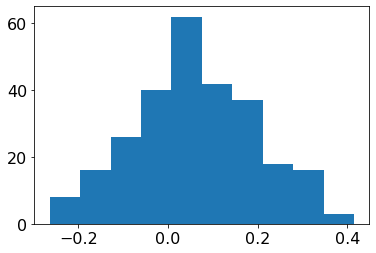

In [66]:
plt.hist(coef_uns_nonsoc)

In [121]:
# soc vs. nonsocial- - other 9 movies. sanity check for timecourse plots
start_time =  time.time()

for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in other_movies:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
        df = df.loc[df['response'] != 9] # yes v no
    
    df['response'] = df['response'].map({0.0: "Non-social", 1.0:  "Social"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)
    if n == 0:
        print(model.fit(factors={"response":["Non-social","Social"]}))
   
    #model.fit(summary = False, verbose = False)
    coef_soc_nonsoc[n] = model.coefs['Estimate'][1]
    pval_soc_nonsoc[n]= model.coefs['P-val'][1]

np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_nonsoc_othermovies.npy'),coef_soc_nonsoc)


node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 7006	 Groups: {'subID': 814.0}

Log-likelihood: -8811.100 	 AIC: 17622.201

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.058  0.241
Residual               0.678  0.824

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.233    0.20    0.267  0.017  2238.946  13.601    0.0  ***
response1       0.159    0.12    0.198  0.020  6328.523   8.005    0.0  ***
node 11,time=0.08 mins
node 21,time=0.14 mins
node 31,time=0.20 mins
node 41,time=0.26 mins
node 51,time=0.32 mins
node 61,time=0.39 mins
node 71,time=0.44 mins
node 81,time=0.51 mins
node 91,time=0.57 mins
node 101,time=0.63 mins
node 111,time=0.69 mins
node 121,time=0.75 mins
node 131,time=0.81 mins
node 141,time=0.87 mins
node 151,time=0.92 mins
node 161,time=0.98 mins
node 171,time=1.

In [123]:
# soc vs. nonsocial - all 10 movies. sanity check for timecourse plots
start_time =  time.time()

for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in range(10):
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
        df = df.loc[df['response'] != 9] # yes v no
    
    df['response'] = df['response'].map({0.0: "Non-social", 1.0:  "Social"})
    model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
    model.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)
    if n == 0:
        print(model.fit(factors={"response":["Non-social","Social"]}))
   
    #model.fit(summary = False, verbose = False)
    coef_soc_nonsoc[n] = model.coefs['Estimate'][1]
    pval_soc_nonsoc[n]= model.coefs['P-val'][1]

np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_nonsoc_allmovies.npy'),coef_soc_nonsoc)


node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 7646	 Groups: {'subID': 814.0}

Log-likelihood: -9553.170 	 AIC: 19106.341

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.061  0.247
Residual               0.666  0.816

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.232   0.200    0.263  0.016  1948.900  14.340    0.0  ***
response1       0.158   0.121    0.195  0.019  7011.355   8.389    0.0  ***
node 11,time=0.07 mins
node 21,time=0.14 mins
node 31,time=0.21 mins
node 41,time=0.28 mins
node 51,time=0.35 mins
node 61,time=0.41 mins
node 71,time=0.48 mins
node 81,time=0.55 mins
node 91,time=0.62 mins
node 101,time=0.68 mins
node 111,time=0.75 mins
node 121,time=0.82 mins
node 131,time=0.88 mins
node 141,time=0.94 mins
node 151,time=1.00 mins
node 161,time=1.05 mins
node 171,time=1.

In [68]:
# FDR-correct all three

pval_soc_uns_corr = lsu(pval_soc_uns,q=.05)
pval_uns_nonsoc_corr = lsu(pval_uns_nonsoc,q=.05)
#pval_soc_nonsoc = lsu(pval_soc_nonsoc,q=.05)
pval_soc_uns_unc  = pval_soc_uns <.05
pval_uns_nonsoc_unc  = pval_uns_nonsoc <.05


In [69]:
# social>unsure and unsure>non-social or vice-versa
nodes_all_SUNS_UNSNS = (pval_soc_uns_corr) & (pval_uns_nonsoc_corr) & (np.sign(coef_soc_uns) == np.sign(coef_uns_nonsoc)) 
len(np.where(nodes_all_SUNS_UNSNS)[0])

59

In [70]:
# nodes common to RANDOM MECH and ALL OTHER MOVIES
common_nodes_soc_uns_nonsoc =  nodes_rand_SUNS_UNSNS_unc & nodes_all_SUNS_UNSNS
np.where(common_nodes_soc_uns_nonsoc)

(array([ 65,  66,  68,  80, 150]),)

In [71]:
rois = [eval(shen268_lbl[str(n+1)][0])['name'] for n in np.where(common_nodes_soc_uns_nonsoc)[0]]
for i,roi in enumerate(rois):
    print(np.where(common_nodes_soc_uns_nonsoc)[0][i],roi)
print(f'\n\n{len(rois)} ROIs sig. at p-value threshold .05\n')

65 35.14% Inferior_Temporal_Gyrus_temporooccipital_part; 29.73% Lateral_Occipital_Cortex_inferior_division; 27.48% Temporal_Occipital_Fusiform_Cortex; 7.66% Occipital_Fusiform_Gyrus
66 54.07% Occipital_Fusiform_Gyrus; 28.60% Lateral_Occipital_Cortex_inferior_division; 14.90% Temporal_Occipital_Fusiform_Cortex
68 48.69% Middle_Temporal_Gyrus_temporooccipital_part; 29.07% Lateral_Occipital_Cortex_inferior_division; 22.09% Inferior_Temporal_Gyrus_temporooccipital_part
80 55.16% Occipital_Pole; 38.06% Lateral_Occipital_Cortex_inferior_division; 6.78% Occipital_Fusiform_Gyrus
150 51.03% Frontal_Orbital_Cortex; 25.77% Inferior_Frontal_Gyrus_pars_triangularis; 11.73% Frontal_Pole; 8.38% Frontal_Operculum_Cortex


5 ROIs sig. at p-value threshold .05



## Plot figures

In [72]:
#import plotting functions

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import plot_glass_brain
import nibabel as nib
from nilearn.plotting import plot_stat_map

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

cols = ['k','k','g']
lw = [3,2,1]

shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
#shen268_lbl


lbl = [str.upper(x[0:4]) for x in vidnames]
lbl



['COAX',
 'BILL',
 'DRIF',
 'FISH',
 'RAND',
 'SCAR',
 'SEDU',
 'STAR',
 'SURP',
 'TENN']

In [73]:
def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii


## Plot RAND MECH

In [28]:
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/unsure_analyses/')


In [75]:
coords = [np.round(eval(shen268_lbl[str(n+1)][0])['coords'][2]) for n in np.where(common_nodes_soc_uns_nonsoc)[0]]
coords

[-15.0, -17.0, -5.0, -11.0, -7.0]

S v. NS: -0.21967760413929566 0.5530003259733386
S v. unsure: -0.1513095294974113 0.42701490941385956
unsure v. NS: -0.268091808634905 0.25409751320748264


<Figure size 720x216 with 0 Axes>

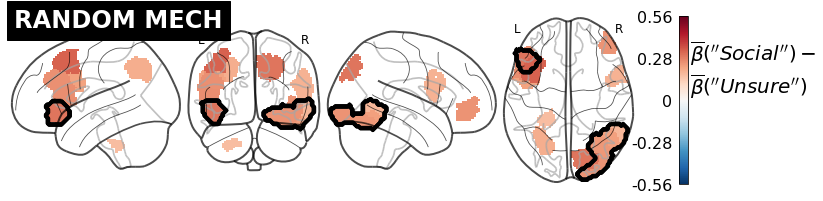

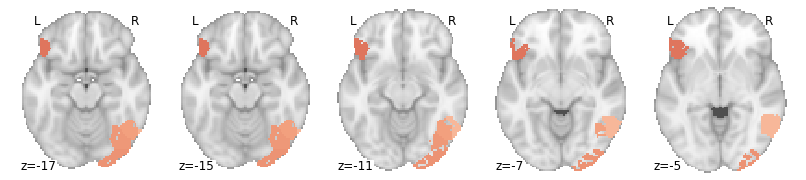

In [76]:
print('S v. NS:', min(meanDiff_sl_rand_S_NS), max(meanDiff_sl_rand_S_NS))
print('S v. unsure:', min(meanDiff_sl_rand_S_UNS), max(meanDiff_sl_rand_S_UNS))
print('unsure v. NS:', min(meanDiff_sl_rand_UNS_NS), max(meanDiff_sl_rand_UNS_NS))

vmin,vmax = -.29,.56

# Social vs. Unsure

txt = r"$\overline{\beta}(''Social'')-$" + '\n' + r"$\overline{\beta}(''Unsure'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
nodes = np.zeros((268,))
nodes[nodes_rand_SUNS_UNSNS_unc] = meanDiff_sl_rand_S_UNS[nodes_rand_SUNS_UNSNS_unc]
img = roi_to_brain(pd.Series(nodes), mask_x)
#img = roi_to_brain(pd.Series(meanDiff_sl_rand_S_UNS), mask_x)
fig=plt.figure(1,figsize=((10,3)))
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True,vmin=vmin,vmax=vmax)
glassb.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.2,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(pval_slope_rand_S_UNS),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
#glassb.add_contours(color_rois(pval_slope_rand_S_UNS_unc),linewidths=lw[1], colors=[[.4,.4,.4,1]],linestyles='dotted')
#glassb.add_contours(color_rois(nodes_rand_SNS_SUNS),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
#glassb.add_contours(color_rois(nodes_rand_SUNS_UNSNS_unc),linewidths=lw[0], colors=[cols[0]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'rand/soc_v_unsure.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')


nodes = np.zeros((268,))
nodes[common_nodes_soc_uns_nonsoc] = meanDiff_sl_rand_S_UNS[common_nodes_soc_uns_nonsoc]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, vmax = vmax,cmap = 'RdBu_r',colorbar=False,annotate=True)
#ax_plot.title('S>Uns,p<.05corr.',fontsize=24,bgcolor='k',color='w',fontweight='bold')
#ax_plot.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'rand/soc_v_unsure_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')


<Figure size 720x216 with 0 Axes>

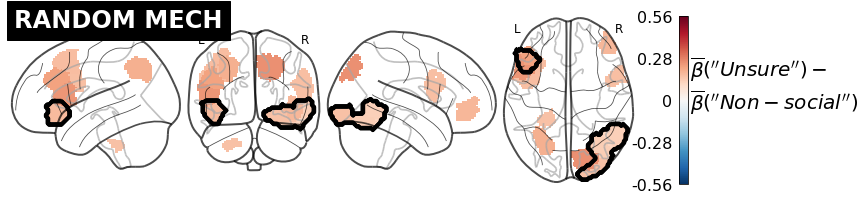

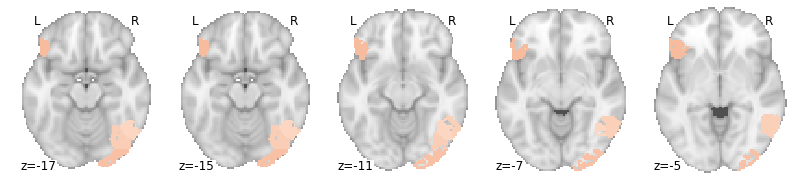

In [77]:
vmin,vmax = -.27,.56

# Rand Unsure >Nonsocial
txt = r"$\overline{\beta}(''Unsure'')-$" + "\n" + r"$\overline{\beta}(''Non-social'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
nodes = np.zeros((268,))
nodes[nodes_rand_SUNS_UNSNS_unc] = meanDiff_sl_rand_UNS_NS[nodes_rand_SUNS_UNSNS_unc]
img = roi_to_brain(pd.Series(nodes), mask_x)
#img = roi_to_brain(pd.Series(meanDiff_sl_rand_UNS_NS), mask_x)
fig=plt.figure(2,figsize=((10,3)))
glassb = plot_glass_brain(img.to_nifti(),vmin=-vmin,vmax=vmax, symmetric_cbar = True,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(pval_slope_rand_UNS_NS_unc),linewidths=[lw[1]], colors=[[.4,.4,.4,1]],linestyles='dotted')
#glassb.add_contours(color_rois(nodes_rand_SNS_SUNS),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
#glassb.add_contours(color_rois(nodes_rand_SUNS_UNSNS_unc),linewidths=lw[0], colors=[cols[0]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'rand/unsure_v_nonsocial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')


nodes = np.zeros((268,))
nodes[common_nodes_soc_uns_nonsoc] = meanDiff_sl_rand_UNS_NS[common_nodes_soc_uns_nonsoc]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, vmax = vmax,cmap = 'RdBu_r',colorbar=False,annotate=True)
#ax_plot.title('Uns>NS,p<.05unc.',fontsize=24,bgcolor='k',color='w',fontweight='bold')

#ax_plot.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'rand/unsure_v_nonsocial_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')


In [78]:
print(min(meanDiff_sl_rand_S_UNS),max(meanDiff_sl_rand_S_UNS))
print(min(meanDiff_sl_rand_UNS_NS),max(meanDiff_sl_rand_UNS_NS))

-0.1513095294974113 0.42701490941385956
-0.268091808634905 0.25409751320748264


### All movies brainmaps

In [79]:
title_txt = 'ALL OTHER MOVIES'
print('All movies: S v Unsure:',min(coef_soc_uns),max(coef_soc_uns))
print('All movies: Unsure v BS:',min(coef_uns_nonsoc),max(coef_uns_nonsoc))


All movies: S v Unsure: -0.3125126449161747 0.7177950067548614
All movies: Unsure v BS: -0.26390429104281937 0.4151339469265551


<Figure size 720x216 with 0 Axes>

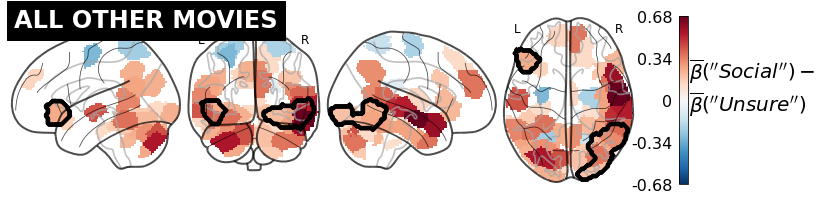

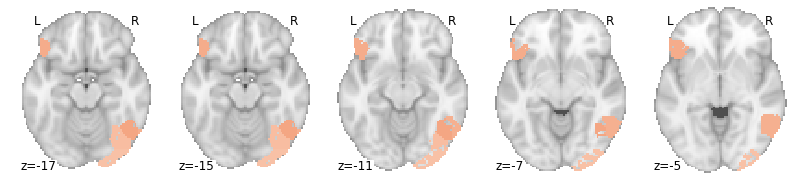

In [80]:
vmin,vmax =-.3,.68

fig=plt.figure(1,figsize=((10,3)))
txt = r"$\overline{\beta}(''Social'')-$" + '\n' + r"$\overline{\beta}(''Unsure'')$"
nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = coef_soc_uns[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
#img = roi_to_brain(pd.Series(coef_soc_uns), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', alpha=0.7, vmin=vmin,vmax= vmax, 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb.add_contours(color_rois(nodes_all_SUNS_UNSNS),linewidths=lw[0], colors=[cols[0]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/social_v_unsure.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
nodes[common_nodes_soc_uns_nonsoc] = coef_soc_uns[common_nodes_soc_uns_nonsoc]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
#ax_plot.title("ALL MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'all_movies/social_v_unsure_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')


<Figure size 720x216 with 0 Axes>

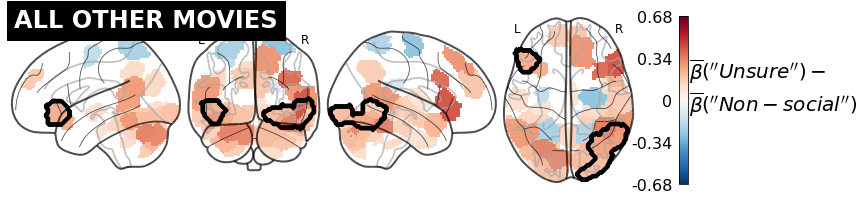

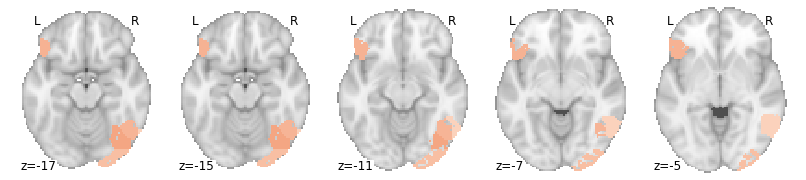

In [81]:
fig=plt.figure(1,figsize=((10,3)))
txt = r"$\overline{\beta}(''Unsure'')-$" + '\n' + r"$\overline{\beta}(''Non-social'')$"
nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = coef_uns_nonsoc[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
#img = roi_to_brain(pd.Series(coef_uns_nonsoc), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', alpha=0.7, vmin=vmin,vmax= vmax, 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb.add_contours(color_rois(nodes_all_SUNS_UNSNS),linewidths=lw[0], colors=[cols[0]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes_soc_uns_nonsoc),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_nonsocial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
nodes[common_nodes_soc_uns_nonsoc] = coef_uns_nonsoc[common_nodes_soc_uns_nonsoc]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
#ax_plot.title("ALL MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_nonsocial_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')



### Correlation plots

In [32]:
# correlation plots

def plot_fig(X,Y,xlabel,ylabel,xymin,xymax):
    #X = stats.zscore(X)
    #X = X/np.nanstd(X)
    #Y = stats.zscore(Y)
    #Y = Y/np.nanstd(Y)
    plt.plot(X,Y,ls='None',marker='.',alpha = .5,color='grey',label = 'mean diff. per node',markersize=8)
    r,p = stats.pearsonr(X,Y)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
   
    #plt.xlabel(xlabel+'/std')
    #plt.ylabel(ylabel+'/std')
    #xmin,xmax = plt.xlim()
    #ymin,ymax = plt.ylim()
    #xymin = min(xmin,ymin)
    #xymax = max(xmax,ymax)

    plt.xlim(xymin,xymax)
    plt.ylim(xymin,xymax)


    xpos = xymin+ .05*(xymax-xymin)
    ypos = xymin+ .8*(xymax-xymin)
    plt.text(xpos,ypos,f'r={r:.2f},\np={p:.1e}',fontsize=20)

    
#def best_fit_line(X,Y):
    m, b = np.polyfit(X,Y, 1)
    print(np.poly1d([m,b]))
    xplot = np.linspace(xymin,xymax,10)
    plt.plot(xplot, m*xplot + b,ls='dashed',color = 'k',label = 'line of best fit\n(all nodes)')
    #plt.title(np.poly1d([m,b]))

    #plt.text(xymin,.7*xymax,f'sl.={m:.2f},\nint.={b:.2f}')
    plt.vlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
    plt.hlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
   

def plot_sig_nodes(X,Y,inds):
    #X = stats.zscore(X)
    #X = X/np.nanstd(X)
    #Y = stats.zscore(Y)
    #Y = Y/np.nanstd(Y)
    plt.plot(X[inds],Y[inds],ls='None',marker='+',
    mfc='k', mec='k',mew = 3, linewidth = 5,label = 'sig. across both axes',ms=12)
    #plt.plot(X[nodes_coaxbill_rand_all_fish],Y[nodes_coaxbill_rand_all_fish],ls='None',marker='D',
    #mfc='g', mec='g',label = 'sig. across all\ncomparisons',ms=10)
    

 
0.09687 x + 0.009471


NameError: name 'common_nodes_soc_uns_nonsoc' is not defined

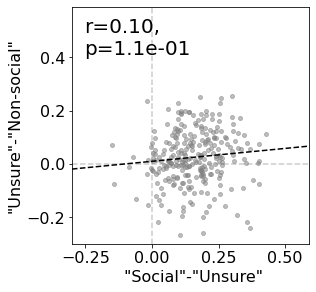

In [35]:
# CHECK THIS CELL AGAIN BEFORE RUNNING NEXT!!!!!!!

dims = [12,9.6]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.3,.59
    
#plt.suptitle('Mean differences: "Social" - "Nonsocial"',fontweight='bold')
ax = fig.add_subplot(221)
X,Y = meanDiff_sl_rand_S_UNS,meanDiff_sl_rand_UNS_NS
plot_fig(X,Y,' "Social"-"Unsure"', '"Unsure"-"Non-social"',xymin,xymax)
ax.set_aspect('equal')
#signodes
plot_sig_nodes(X,Y,common_nodes_soc_uns_nonsoc)
#plt.plot(X[nodes_rand_SUNS_UNSNS_unc],Y[nodes_rand_SUNS_UNSNS_unc],mec='k',marker='o',mfc='none',ls='None')
#plt.title('RANDOM MECH')
#plt.legend(bbox_to_anchor = (1,1),fontsize =16)
plt.title('RANDOM MECH',fontweight='bold')

plt.xticks([np.round(i,2) for i in np.linspace(xymin*10,xymax*10,4)/10])
plt.yticks([np.round(i,2) for i in np.linspace(xymin*10,xymax*10,4)/10])


#plt.suptitle('Mean differences: "Social" - "Nonsocial"',fontweight='bold')
'''ax = fig.add_subplot(223)
X,Y = meanDiff_sl_rand_S_UNS,meanDiff_sl_rand_S_NS
plot_fig(X,Y,'"Social"-"Unsure"',' "Social"-"Non-social"',xymin,xymax)
ax.set_aspect('equal')
#signodes
plot_sig_nodes(X,Y,nodes_rand_SNS_SUNS)


plt.tight_layout()'''

plt.savefig(os.path.join(fig_save_loc,'rand/rand_soc_v_unsure_v_nonsoc_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')


## All movies, plot scatterplot and brainmaps : S>Unsure > NS

 
0.1279 x + 0.05142


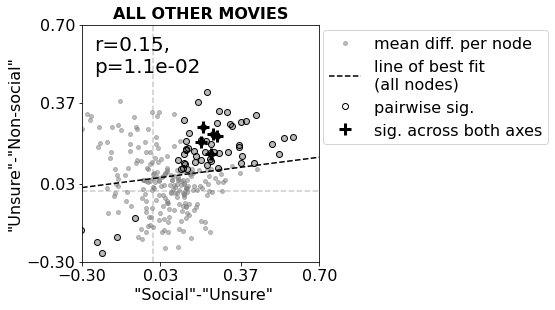

In [114]:
# scatterplot
dims = [12,9.6]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.3,.7
#plt.suptitle('Mean differences: "Social" - "Nonsocial"',fontweight='bold')
ax = fig.add_subplot(221)
X,Y = coef_soc_uns,coef_uns_nonsoc
plot_fig(X,Y,' "Social"-"Unsure"','"Unsure"-"Non-social"',xymin,xymax)
ax.set_aspect('equal')
#signodes
plt.plot(X[nodes_all_SUNS_UNSNS],Y[nodes_all_SUNS_UNSNS],mec='k',marker='o',mfc='none',markersize=6,ls='None',label = 'pairwise sig.')
plot_sig_nodes(X,Y,common_nodes_soc_uns_nonsoc)
#plt.plot(X[nodes_all_SUNS_UNSNS],Y[nodes_all_SUNS_UNSNS],mec='k',marker='o',mfc='none',ls='None')
plt.title('ALL OTHER MOVIES',fontweight='bold')
plt.legend(bbox_to_anchor = (2,1.01),fontsize =16)
plt.xlim(xymin,xymax)
plt.ylim(xymin,xymax)
plt.xticks([np.round(i,2) for i in np.linspace(-3,7,4)/10])
plt.yticks([np.round(i,2) for i in np.linspace(-3,7,4)/10])
plt.savefig(os.path.join(fig_save_loc,'all_movies/all_soc_v_unsure_v_nonsoc_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')




# Unsure > sure

### 1.  Random Mech

In [18]:
movie_ind = 4
coef_slope_rand = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','coef_slopereg_runnorm_Random mechanical.npy'))

soc_inds = responses[:,movie_ind]==1 # subs who responded "social"
nonsoc_inds = responses[:,movie_ind]==0 # subs who respoded "nonsocial"
unsure_inds = responses[:,movie_ind]==9 # subs who respoded "unsure"

_,pval_slope_rand_unsure_sure_unc = stats.ttest_ind(coef_slope_rand[unsure_inds,:],coef_slope_rand[soc_inds|nonsoc_inds,:], axis=0, equal_var=False)
pval_slope_rand_unsure_sure = lsu(pval_slope_rand_unsure_sure_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_unsure_sure = np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)-np.nanmean(coef_slope_rand[soc_inds|nonsoc_inds,:],axis=0)

pval_slope_rand_unsure_sure_unc = pval_slope_rand_unsure_sure_unc<.05

print('unc.:',len(np.where(pval_slope_rand_unsure_sure_unc)[0]))
print('corr.:',len(np.where(pval_slope_rand_unsure_sure)[0]))


unc.: 37
corr.: 0


In [19]:
all_coefs = np.zeros((1048,268,10))

for m in range(10):
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg', f'coef_slopereg_runnorm_{vidnames[m]}.npy')
    
    all_coefs[:,:,m] = np.load(fileName)
    #print(dat.shape)

In [20]:
# initializing arrays
coef_unsure_sure = np.empty((268,))
coef_unsure_sure[:]  = np.nan

pval_unsure_sure = np.empty((268,))
pval_unsure_sure[:]= np.nan

start_time =  time.time()
for n in range(268):
    if n%10 == 0:
        print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
    df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
    for m in other_movies:
        df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
        df = df.append(df_temp,ignore_index=True)
    
    df['uncertainty'] = ['Uncertain' if i == 9 else 'Certain' for i in df['response'].values]
        
    model = Lmer('coefs ~  uncertainty + (1|subID)', data=df) # ff: mean response, rf:subjID
    #print('model 4:',model.fit())
    model.fit(factors={"uncertainty":["Certain","Uncertain"]},summary = False, verbose = False)
    if n == 0:
        print(model.fit(factors={"uncertainty":["Certain","Uncertain"]}))
    #model.fit(summary = False, verbose = False)
    coef_unsure_sure[n] = model.coefs['Estimate'][1]
    pval_unsure_sure[n]= model.coefs['P-val'][1]



node 1,time=0.00 mins
Formula: coefs~uncertainty+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 7326	 Groups: {'subID': 814.0}

Log-likelihood: -9241.968 	 AIC: 18483.937

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.057  0.239
Residual               0.685  0.828

No random effect correlations specified

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)      0.323   0.298    0.348  0.013   853.368  24.909  0.000  ***
uncertainty1    -0.070  -0.165    0.026  0.049  7269.770  -1.429  0.153     
node 11,time=0.10 mins
node 21,time=0.17 mins
node 31,time=0.23 mins
node 41,time=0.30 mins
node 51,time=0.36 mins
node 61,time=0.43 mins
node 71,time=0.50 mins
node 81,time=0.56 mins
node 91,time=0.63 mins
node 101,time=0.69 mins
node 111,time=0.75 mins
node 121,time=0.82 mins
node 131,time=0.89 mins
node 141,time=0.95 mins
node 151,time=1.01 mins
node 161,time=1.07 mins
node 171,t

In [21]:
pval_unsure_sure1 = lsu(pval_unsure_sure,q=.05)
len(np.where(pval_unsure_sure1)[0])

67

### Plot brainmaps and scatterplots for all movies' analyses

## Unsure > Sure

In [22]:
all_nodes_unsure_greaterthan_sure = pval_unsure_sure1 & (coef_unsure_sure>0)
len(np.where(all_nodes_unsure_greaterthan_sure)[0])


23

In [23]:
rand_nodes_unsure_greaterthan_sure = pval_slope_rand_unsure_sure_unc & (meanDiff_sl_rand_unsure_sure>0)
len(np.where(rand_nodes_unsure_greaterthan_sure)[0])

16

In [24]:
common_nodes = rand_nodes_unsure_greaterthan_sure & all_nodes_unsure_greaterthan_sure
len(np.where(common_nodes)[0])

7

## all movies unsure v sure

In [25]:
coords = [np.round(eval(shen268_lbl[str(n+1)][0])['coords'][2]) for n in np.where(common_nodes)[0]]
coords

NameError: name 'shen268_lbl' is not defined

In [ ]:
rois = [eval(shen268_lbl[str(n+1)][0])['coords'][2] for n in np.where(common_nodes)[0]]
for i,n in enumerate(rois):
    print(np.where(common_nodes)[0][i],n)
print(f'{len(rois)} ROIs sig. at p-value threshold .05\n')

27 48.63713080168776
35 -10.065637065637063
149 46.21328671328672
154 5.882562277580064
155 10.640382317801667
176 40.42461538461538
218 26.288065843621396
7 ROIs sig. at p-value threshold .05



In [ ]:
rois = [eval(shen268_lbl[str(n+1)][0])['name'] for n in np.where(common_nodes)[0]]
for i,n in enumerate(rois):
    print(np.where(common_nodes)[0][i],n)
print(f'{len(rois)} ROIs sig. at p-value threshold .05\n')

27 41.56% Paracingulate_Gyrus; 27.43% Superior_Frontal_Gyrus; 21.52% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex); 9.49% Cingulate_Gyrus_anterior_division
35 60.69% Frontal_Orbital_Cortex; 31.21% Insular_Cortex; 6.36% Temporal_Pole
149 59.27% Paracingulate_Gyrus; 30.42% Superior_Frontal_Gyrus; 6.82% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex)
154 41.28% Frontal_Operculum_Cortex; 40.39% Insular_Cortex; 12.28% Frontal_Orbital_Cortex; 5.69% Inferior_Frontal_Gyrus_pars_triangularis
155 59.98% Inferior_Frontal_Gyrus_pars_opercularis; 29.99% Inferior_Frontal_Gyrus_pars_triangularis; 5.50% Frontal_Operculum_Cortex
176 68.85% Lateral_Occipital_Cortex_superior_division; 21.93% Superior_Parietal_Lobule; 7.48% Angular_Gyrus
218 63.37% Paracingulate_Gyrus; 30.73% Cingulate_Gyrus_anterior_division; 5.90% Superior_Frontal_Gyrus
7 ROIs sig. at p-value threshold .05



-0.2556920696778834 0.20894016749339722


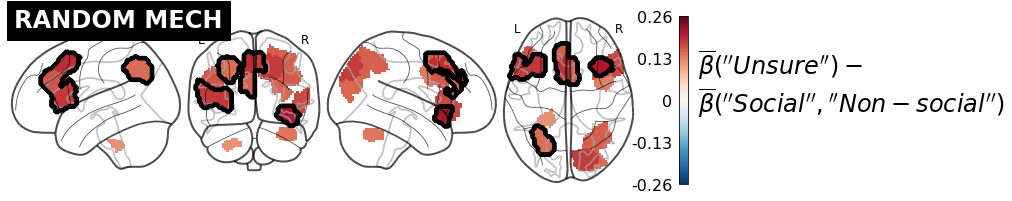

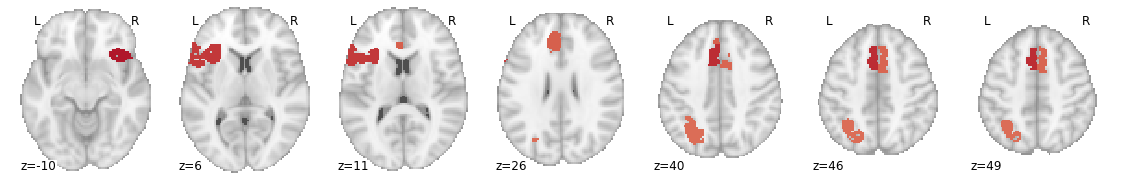

In [111]:

vmin,vmax = min(meanDiff_sl_rand_unsure_sure),max(meanDiff_sl_rand_unsure_sure)
print(vmin,vmax)
vmax = .26

nodes = np.zeros((268,))
#nodes[all_nodes_unsure_greaterthan_sure] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure]
nodes[rand_nodes_unsure_greaterthan_sure] = meanDiff_sl_rand_unsure_sure[rand_nodes_unsure_greaterthan_sure]
img = roi_to_brain(pd.Series(nodes), mask_x)


txt = r"$\overline{\beta}(''Unsure'')-$" +'\n'+ r"$\overline{\beta}(''Social'',''Non-social'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
glassb = plot_glass_brain(img.to_nifti(), symmetric_cbar = True, title = 'RANDOM MECH',
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True,vmax=vmax)
glassb.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.05,txt,fontsize=24,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(rand_nodes_unsure_greaterthan_sure),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'rand/unsure_v_sure.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
#nodes[rand_nodes_unsure_greaterthan_sure] = meanDiff_sl_rand_unsure_sure[rand_nodes_unsure_greaterthan_sure]
nodes[common_nodes] = meanDiff_sl_rand_unsure_sure[common_nodes]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, vmax = vmax,cmap = 'RdBu_r',colorbar=False,annotate=True)
#ax_plot.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'rand/unsure_v_sure_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')



-0.34809065043255083 0.29865647724689826


<Figure size 720x216 with 0 Axes>

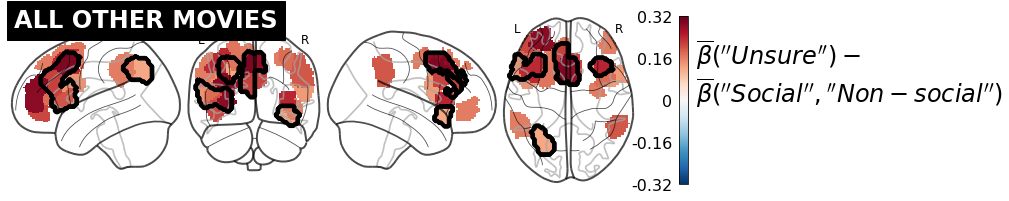

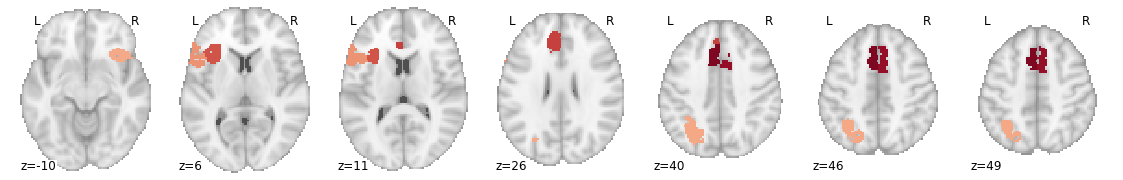

In [102]:

vmin,vmax = min(coef_unsure_sure),max(coef_unsure_sure)
print(vmin,vmax)
vmax = .32

nodes = np.zeros((268,))
#nodes[all_nodes_unsure_greaterthan_sure] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure]
nodes[all_nodes_unsure_greaterthan_sure] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure]
img = roi_to_brain(pd.Series(nodes), mask_x)

fig=plt.figure(1,figsize=((10,3)))
txt = r"$\overline{\beta}(''Unsure'')-$" + '\n' + r"$\overline{\beta}(''Social'',''Non-social'')$"
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', alpha=0.7, vmin=vmin,vmax= vmax, 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title("ALL OTHER MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=24,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb.add_contours(color_rois(all_nodes_unsure_greaterthan_sure),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(common_nodes),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_sure.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
#nodes[all_nodes_unsure_greaterthan_sure] = coef_unsure_sure[all_nodes_unsure_greaterthan_sure]
nodes[common_nodes] = coef_unsure_sure[common_nodes]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=coords, cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
#ax_plot.title("ALL OTHER MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_sure_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')



In [116]:
fig_save_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/unsure_analyses/'

In [118]:
print(min(meanDiff_sl_rand_unsure_sure),max(meanDiff_sl_rand_unsure_sure))
print(min(coef_unsure_sure),max(coef_unsure_sure))

-0.2556920696778834 0.20894016749339722
-0.34809065043255083 0.29865647724689826


 
0.5821 x - 0.02227


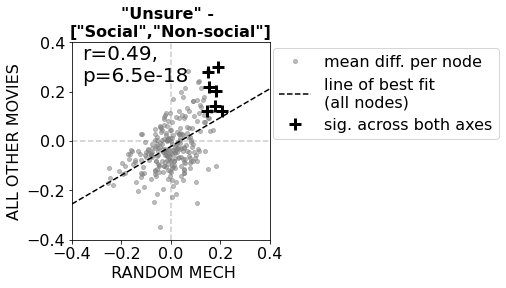

In [34]:
dims = [10,8]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.4,.4
ax = fig.add_subplot(221) #meanDiff_sl_rand_unsure_sure[rand_nodes_unsure_greaterthan_surea]
X,Y = meanDiff_sl_rand_unsure_sure,coef_unsure_sure
plot_fig(X,Y,' RANDOM MECH','ALL OTHER MOVIES',xymin,xymax)
ax.set_aspect('equal')
#signodes
plot_sig_nodes(X,Y,common_nodes)
#plt.plot(X[nodes_all_SUNS_UNSNS],Y[nodes_all_SUNS_UNSNS],mec='k',marker='o',mfc='none',ls='None')
plt.title('"Unsure" - \n["Social","Non-social"]',fontweight ='bold')
plt.legend(bbox_to_anchor = (2.2,1.01),fontsize =16)
plt.savefig(os.path.join(fig_save_loc,'rand_v_all_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')



# extra code

In [ ]:
from multipy.fdr import lsu
#from multipy.data import neuhaus

significant_pvals = lsu(np.array(x), q=0.01)
#print(zip(['{:.4f}'.format(p) for p in x], significant_pvals))
significant_pvals

In [ ]:
nodes = np.zeros((268,))
nodes[pval_slope_coaxbill] = meanDiff_sl_coaxbill[pval_slope_coaxbill]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)


img = roi_to_brain(pd.Series(meanDiff_sl_coaxbill), mask_x)
#txt = 'COAX-BILL [' + r'$\overline{\beta_{social}-{\beta}_{nonsocial}}$' + ']'
txt = r'$\overline{\beta_{social}-{\beta}_{nonsocial}}$'
#txt = f"COAXBILL"
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
glassb = plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb.add_contours(color_rois(pval_slope_coaxbill),linewidths=lw[1], colors=[cols[1]],linestyle='dashed')
glassb.add_contours(color_rois(nodes_coaxbill_rand_all),linewidths=lw[0], colors=[cols[0]],linestyle='dashed')
#glassb.add_contours(color_rois(nodes_coaxbill_rand_all_fish),linewidths=lw[2], colors=[cols[2]],filled=True,linestyle='dashed')



In [ ]:
### fish
# same movie: fish

movie_ind = 3

soc_inds = responses[:,movie_ind]==1 # subs who responded "social"
nonsoc_inds = responses[:,movie_ind]==0 # subs who respoded "nonsocial"

print(f'movie={vid_joined[movie_ind]},soc={len(np.where(soc_inds)[0])},nonsocial={len(np.where(nonsoc_inds)[0])}')

# ttest between slope regs yes vs. no
_,pval_slope_fish = stats.ttest_ind(coef_slope_fish[soc_inds,:], coef_slope_fish[nonsoc_inds,:],axis=0, equal_var=False)
meanDiff_sl_fish = np.nanmean(coef_slope_fish[soc_inds,:],axis=0)-np.nanmean(coef_slope_fish[nonsoc_inds,:],axis=0)

#fdr correction
#_,pval_slope_fish = fdr_correction(pval_slope_fish,.05)
pval_slope_fish = lsu(pval_slope_fish,q=.05)

dirn_fish = np.empty((268,))
count=0
for n in range(268):
    if np.abs(np.nanmean(coef_slope_fish[soc_inds,n],axis=0)) > np.abs(np.nanmean(coef_slope_fish[nonsoc_inds,n],axis=0)):
        dirn_fish[n] = 1
    elif np.abs(np.nanmean(coef_slope_fish[soc_inds,n],axis=0)) < np.abs(np.nanmean(coef_slope_fish[nonsoc_inds,n],axis=0)):
        dirn_fish[n] = -1
    else:
        dirn_fish[n] = 0

In [ ]:
## all movies t-tests (doesn't consider shared variance between subs - but good to get an initial impression)

coef_trial_resh_yes = []
coef_trial_resh_unsure = []
coef_trial_resh_no = []

for m in range(10):
    fileName =  os.path.join(data_file_loc,f'coef_slopereg_trialnorm_{vidnames[m]}.npy')
    coefs_ = np.load(fileName)
    #print(dat.shape)
    coef_trial_resh_yes.append(coefs_[responses[:,m]==1,:])# subsm * 268 * nt0
    coef_trial_resh_no.append(coefs_[responses[:,m]==0,:])# subsm * 268 * nt1
    coef_trial_resh_unsure.append(coefs_[responses[:,m]==9,:])# subsm * 268 * nt2

coef_trial_resh_yes = np.concatenate(coef_trial_resh_yes,axis=0)
coef_trial_resh_no = np.concatenate(coef_trial_resh_no,axis=0)
coef_trial_resh_unsure = np.concatenate(coef_trial_resh_unsure,axis=0)
print('Across movies: \n\tyes:'+ str(coef_trial_resh_yes.shape) + ',no:' + str(coef_trial_resh_no.shape)+ ',unsure:' + str(coef_trial_resh_unsure.shape))


# ttest between slope regs yes vs. no
_,pval_slope_all_S_NS = stats.ttest_ind(coef_trial_resh_yes, coef_trial_resh_no, axis=0, equal_var=False)
pval_slope_all_S_NS = lsu(pval_slope_all_S_NS,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_all_S_NS = np.nanmean(coef_trial_resh_yes,axis=0)-np.nanmean(coef_trial_resh_no,axis=0)

# ttest between slope regs yes vs. unsure
_,pval_slope_all_S_UNS = stats.ttest_ind(coef_trial_resh_yes, coef_trial_resh_unsure, axis=0, equal_var=False)
pval_slope_all_S_UNS = lsu(pval_slope_all_S_UNS,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_all_S_UNS = np.nanmean(coef_trial_resh_yes,axis=0)-np.nanmean(coef_trial_resh_unsure,axis=0)

# ttest between slope regs unsure vs. no
_,pval_slope_all_UNS_NS_unc = stats.ttest_ind(coef_trial_resh_unsure, coef_trial_resh_no,axis=0, equal_var=False)
pval_slope_all_UNS_NS = lsu(pval_slope_all_UNS_NS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_all_UNS_NS = np.nanmean(coef_trial_resh_unsure,axis=0)-np.nanmean(coef_trial_resh_no,axis=0)

#pval_slope_all_UNS_NS_unc = pval_slope_all_UNS_NS_unc<.05


_,pval_slope_all_unsure_sure = stats.ttest_ind(coef_trial_resh_unsure,np.concatenate((coef_trial_resh_yes,coef_trial_resh_no)), axis=0, equal_var=False)
pval_slope_all_unsure_sure = lsu(pval_slope_all_unsure_sure,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_all_unsure_sure = np.nanmean(coef_trial_resh_unsure,axis=0)-np.nanmean(np.concatenate((coef_trial_resh_yes,coef_trial_resh_no)),axis=0)


In [ ]:
# social>unsure and unsure>non-social or vice-versa
nodes_all_SUNS_UNSNS = (pval_slope_all_S_UNS) & (pval_slope_all_UNS_NS) & (np.sign(meanDiff_sl_all_S_UNS) == np.sign(meanDiff_sl_all_UNS_NS)) 
len(np.where(nodes_all_SUNS_UNSNS)[0])


print('All movies: S v Unsure:',min(meanDiff_sl_all_S_UNS),max(meanDiff_sl_all_S_UNS))
print('All movies: Unsure v BS:',min(meanDiff_sl_all_UNS_NS),max(meanDiff_sl_all_UNS_NS))


In [ ]:
nodes = np.zeros((268,))
nodes[pval_slope_all_S_UNS] = meanDiff_sl_all_S_UNS[pval_slope_all_S_UNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = True, vmin=vmin,vmax= vmax,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)

nodes = np.zeros((268,))
nodes[pval_slope_all_UNS_NS] = meanDiff_sl_all_UNS_NS[pval_slope_all_UNS_NS]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = True, vmin=vmin,vmax=vmax,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)


In [ ]:
fig=plt.figure(1,figsize=((10,3)))
txt = r"$\overline{\beta}(''Social'')-$" + '\n' + r"$\overline{\beta}(''Unsure'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
img = roi_to_brain(pd.Series(meanDiff_sl_all_S_UNS), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', alpha=0.7, vmin=vmin,vmax= vmax, 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title("ALL MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(pval_slope_all_S_UNS),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(nodes_all_SUNS_UNSNS),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/social_v_unsure.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

fig=plt.figure(2,figsize=((10,3)))
nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = meanDiff_sl_all_S_UNS[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
output_file = os.path.join(fig_save_loc,'all_movies/social_v_unsure_axial.png')
plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=10*np.arange(-4,6,2), cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
plt.savefig(output_file,dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')



fig=plt.figure(3,figsize=((10,3)))
txt = r"$\overline{\beta}(''Unsure'')-$" + '\n' + r"$\overline{\beta}(''Non-social'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
img = roi_to_brain(pd.Series(meanDiff_sl_all_UNS_NS), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = True, title='ALL MOVIES', vmin=vmin,vmax= vmax,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb.title("ALL MOVIES",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.1,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(pval_slope_all_UNS_NS),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(nodes_all_SUNS_UNSNS),linewidths=lw[0], colors=[cols[0]],linestyles='solid')
plt.savefig(os.path.join(fig_save_loc,'all_movies/unsure_v_nonsocial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

fig=plt.figure(4,figsize=((10,3)))
nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = meanDiff_sl_all_UNS_NS[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
output_file = os.path.join(fig_save_loc,'all_movies/unsure_v_nonsocial_axial.png')
plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=10*np.arange(-4,6,2), cmap = 'RdBu_r',vmax=vmax,colorbar=False,annotate=True)
plt.savefig(output_file,dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')




In [ ]:
nodes_all_UNS_SURE= (pval_slope_all_S_NS) & (pval_slope_all_UNS_NS) &(~pval_slope_all_S_NS) & (np.sign(meanDiff_sl_all_S_UNS) == -1) & (np.sign(meanDiff_sl_all_UNS_NS)==1) 
len(np.where(nodes_all_UNS_SURE)[0])

# social>nonsocial and social>unsure or vice-versas

In [ ]:

fig = plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True,vmin=-.22,vmax=.55)
#fig._show_colorbar(plt.get_cmap('RdBu_r'), MidpointNormalize(midpoint=0., vmin=cmin, vmax=cmax))
#box = fig._colorbar_ax.get_position()
#total_cols=5
#fig._colorbar_ax.set_p9osition([box.x0+(box.x0*0.1/total_cols), box.y0, box.width, box.height])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
#fig._colorbar_ax.set_label('xxxxxxxxxxxx')
fig._colorbar_ax.set_title('xx')#get_legend()
fig._colorbar_ax.set_xticklabels({-1:'-1',0:'0',1:'1'})#get_legend()

ax = plt.gcf().axes[5].axis() #plt.gcf().axes[i].set_label('abc'+str(i))# rmatter(ticker.FormatStrFormatter("%i")))
plt.gcf().axes[5].axis()


In [ ]:
# looks weird.. so sanity checks

nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = meanDiff_sl_all_S_UNS[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)

nodes = np.zeros((268,))
nodes[nodes_all_SUNS_UNSNS] = meanDiff_sl_all_UNS_NS[nodes_all_SUNS_UNSNS]
img = roi_to_brain(pd.Series(nodes), mask_x)
plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)


In [ ]:
nodes=  np.zeros((268,))
nodes[pval_slope_all_unsure_sure] = meanDiff_sl_all_unsure_sure[pval_slope_all_unsure_sure]
img = roi_to_brain(pd.Series(nodes), mask_x)
img.plot(colorbar=True,cmap = 'RdBu_r',title='ALL MOVIES', symmetric_cbar = False)


txt = r'$\overline{\beta}_{unsure}-\overline{\beta}_{social,nonsocial}$'
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
img = roi_to_brain(pd.Series(meanDiff_sl_all_unsure_sure), mask_x)
glassb = plot_glass_brain(img.to_nifti(),symmetric_cbar = False, title='ALL MOVIES', 
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
#glassb.add_contours(color_rois(pval_slope_all_S_UNS),linewidths=lw[1], colors=[cols[1]],linestyles='dotted')
glassb.add_contours(color_rois(pval_slope_all_unsure_sure),linewidths=lw[0], colors=[cols[0]],linestyles='solid')




plt.hist(meanDiff_sl_all_unsure_sure,bins=20,color='grey')
plt.xlabel(r'$\overline{\beta}_{unsure}>\overline{\beta}_{social,nonsocial}$')
plt.ylabel('Number of nodes')
ymin,ymax=plt.ylim()
plt.vlines(np.nanmean(meanDiff_sl_all_unsure_sure),ymin,ymax,color='k',label='Mean')
plt.legend()
plt.title('ALL MOVIES')

In [ ]:
plt.hist(meanDiff_sl_rand_unsure_sure,bins=20,color='grey')
plt.xlabel(r'$\overline{\beta}_{unsure}>\overline{\beta}_{social,nonsocial}$')
plt.ylabel('Number of nodes')
ymin,ymax=plt.ylim()
plt.vlines(np.nanmean(meanDiff_sl_rand_unsure_sure),ymin,ymax,color='k',label='Mean')
plt.legend()
plt.title('RANDOM MECH')

# extra 

In [ ]:

txt = r"$\overline{\beta}(''Social'')-$" + '\n' + r"$\overline{\beta}(''Non-social'')$"
#txt = 'RANDOM MECH [' + r'$\overline{\beta}_{social}-\overline{\beta}_{nonsocial}$' + ']'
#img.plot(colorbar=True, title = txt,cmap = 'RdBu_r',symmetric_cbar = False)
img = roi_to_brain(pd.Series(meanDiff_sl_rand_S_NS), mask_x)
fig=plt.figure(2,figsize=((10,3)))
glassb = plot_glass_brain(img.to_nifti(), symmetric_cbar = True,
                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True,vmax=vmax)
#glassb.title(txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
glassb._colorbar_ax.text(0.9,0.2,txt,fontsize=20,fontdict = {'verticalalignment':'center','rotation':0})#get_legend()
#glassb._colorbar_ax.set_title(txt,fontsize=20)#get_legend()
#glassb._colorbar_ax.set_position([0.999,0.01,.05,.95])
#glassb._colorbar_ax.orientation = 'vertical'#glassb._colorbar_ax.set_snap]
#glassb._colorbar_margin['top'] = .1
glassb.add_contours(color_rois(pval_slope_rand_S_NS),linewidths=lw[1], colors=[cols[1]],linestyles='dotted') #this contrast
glassb.add_contours(color_rois(nodes_rand_SNS_SUNS),linewidths=lw[0], colors=[cols[0]],linestyles='solid') # all contrasts
plt.savefig(os.path.join(fig_save_loc,'rand/soc_v_nonsoc.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

nodes = np.zeros((268,))
nodes[pval_slope_rand_S_NS] = meanDiff_sl_rand_S_NS[pval_slope_rand_S_NS]
img = roi_to_brain(pd.Series(nodes), mask_x)
#plot_glass_brain(img.to_nifti(),symmetric_cbar = False,
#                display_mode='lyrz', plot_abs=False, black_bg=False,cmap = 'RdBu_r',colorbar = True)
ax_plot = plot_stat_map(img.to_nifti(), display_mode='z', cut_coords=10*np.arange(-4,7,2), vmax = vmax,cmap = 'RdBu_r',colorbar=True,annotate=True)
ax_plot.title('S>NS,p<.05corr',fontsize=24,bgcolor='k',color='w',fontweight='bold')

#ax_plot.title("RANDOM MECH",fontsize=24,bgcolor='k',color='w',fontweight='bold')
plt.savefig(os.path.join(fig_save_loc,'rand/soc_v_nonsoc_axial.png'),dpi=600,bbox_inches='tight',facecolor='white', edgecolor='none')


In [ ]:
#### social>(NS and unsure) or vice-versa
# # social>nonsocial and social>unsure or vice-versa
#nodes_rand_SNS_SUNS = (pval_slope_rand_S_NS) & (pval_slope_rand_S_UNS) & (np.sign(meanDiff_sl_rand_S_NS) == np.sign(meanDiff_sl_rand_S_UNS)) 
#print('nodes_rand_SNS_SUNS:',len(np.where(nodes_rand_SNS_SUNS)[0]))
